# Data Preparation

## Load Data

In [ ]:
import os
import re

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
# from entropy import spectral_entropy
# from keras import layers
# from keras import models
# from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import itertools, torch, sys, random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Paths to
Crema = "../input/speech-emotion-recognition-en/Crema"

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [ ]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

,Emotion,Path
0,disgust,../input/speech-emotion-recognition-en/Crema/1...
1,happy,../input/speech-emotion-recognition-en/Crema/1...
2,happy,../input/speech-emotion-recognition-en/Crema/1...
3,disgust,../input/speech-emotion-recognition-en/Crema/1...
4,disgust,../input/speech-emotion-recognition-en/Crema/1...


In [ ]:
df = pd.concat([Crema_df], axis=0)
df.shape

(7442, 2)

In [ ]:
%matplotlib inline

plt.style.use("ggplot")

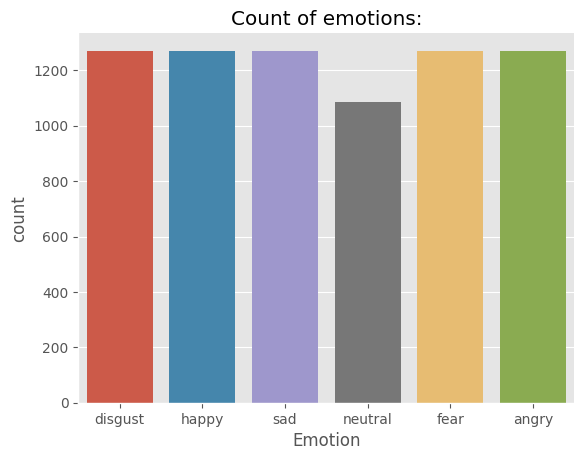

In [ ]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

## Listen to and Plot each Class

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

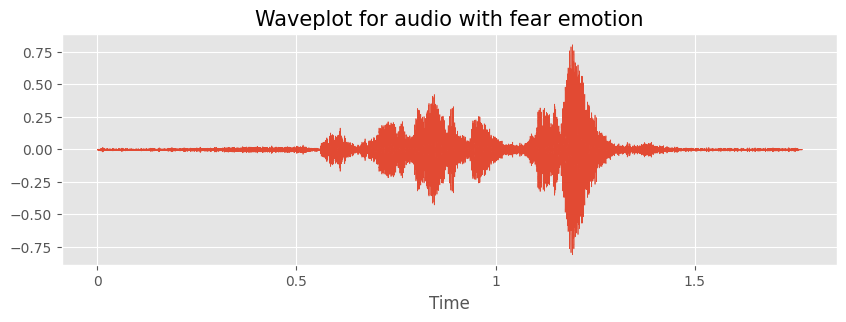

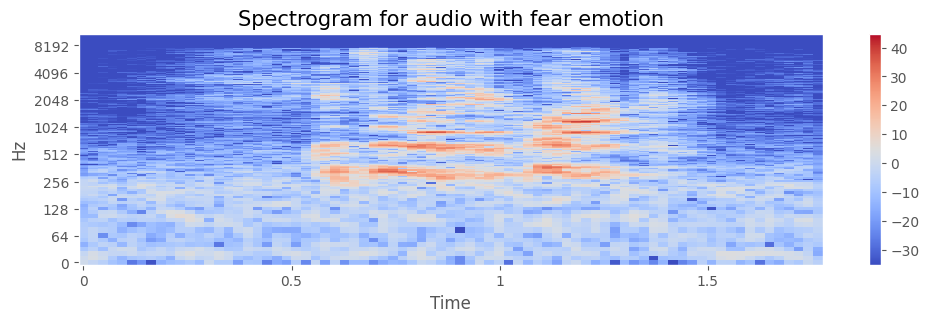

In [ ]:
emotion='fear'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

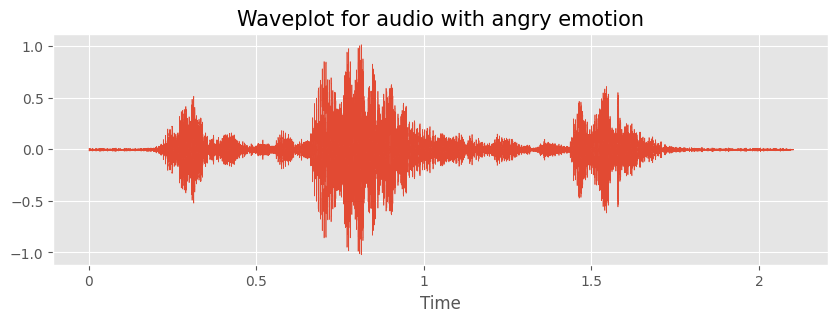

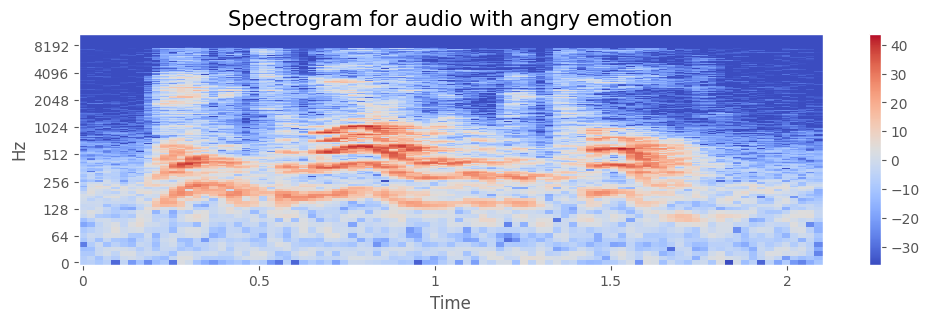

In [ ]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

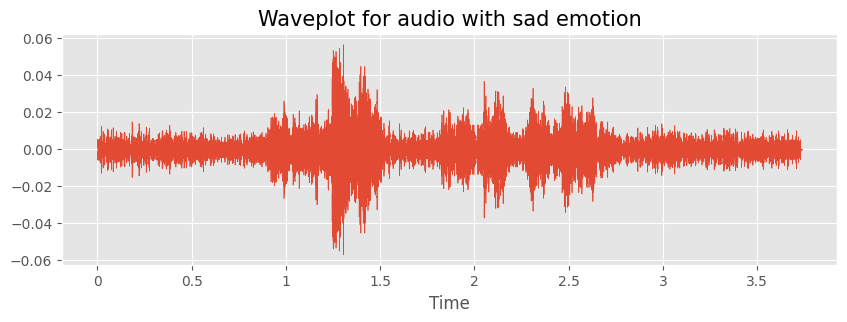

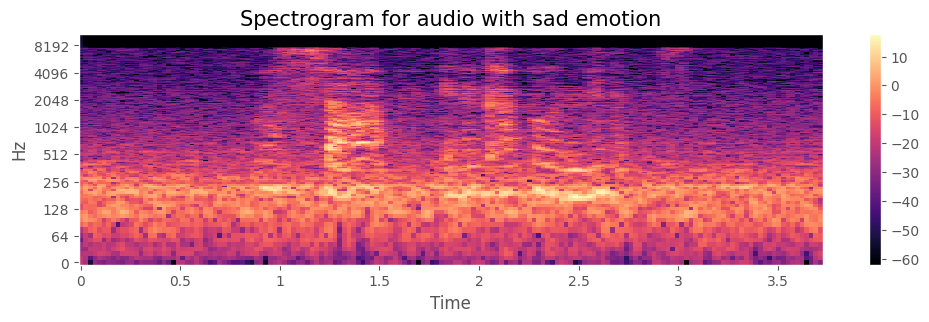

In [ ]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## 1D

### Data augmentation

We have some ways for data augmentation in sound data:

1. Noise injection
2. Stretching
3. Shifting
4. Pitching

In [ ]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
df.head()

,Emotion,Path
0,disgust,../input/speech-emotion-recognition-en/Crema/1...
1,happy,../input/speech-emotion-recognition-en/Crema/1...
2,happy,../input/speech-emotion-recognition-en/Crema/1...
3,disgust,../input/speech-emotion-recognition-en/Crema/1...
4,disgust,../input/speech-emotion-recognition-en/Crema/1...


In [ ]:
path = df[df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

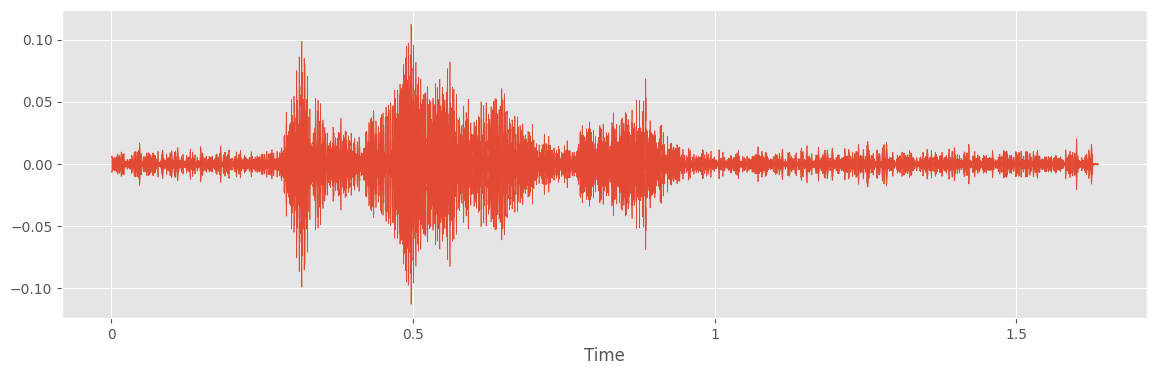

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(data, sr=sampling_rate)
Audio(path)

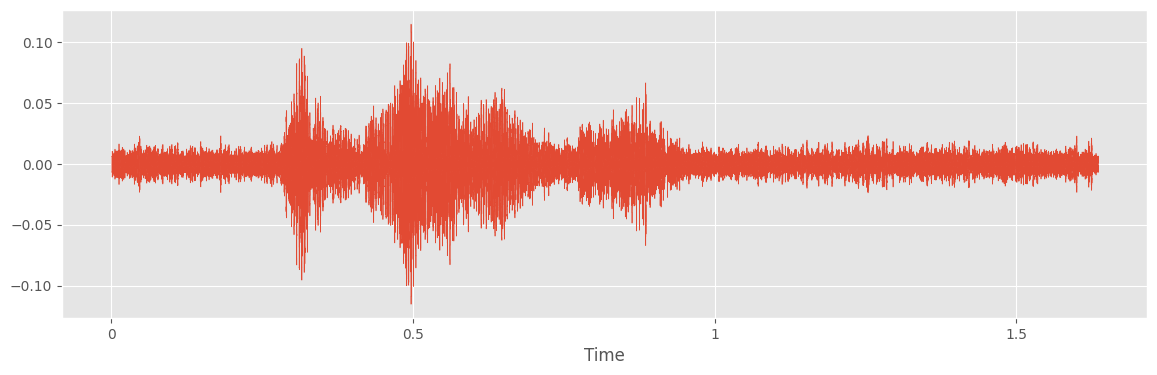

In [ ]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)


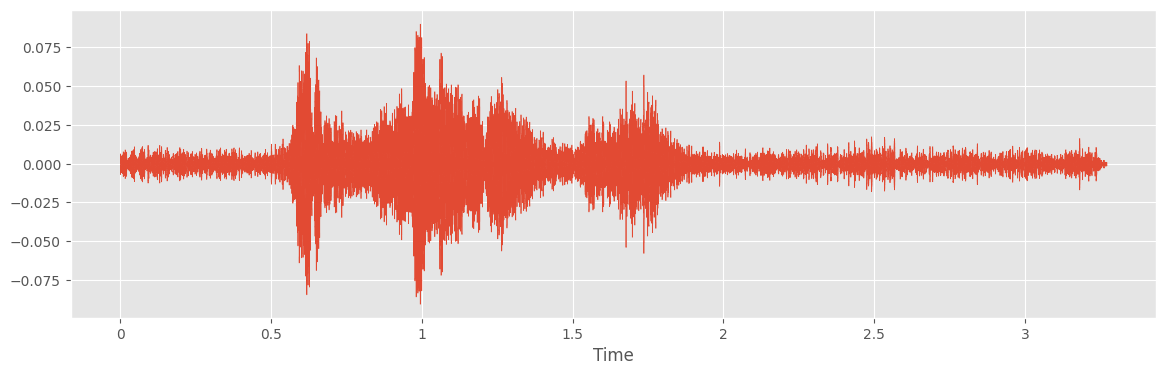

In [ ]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)


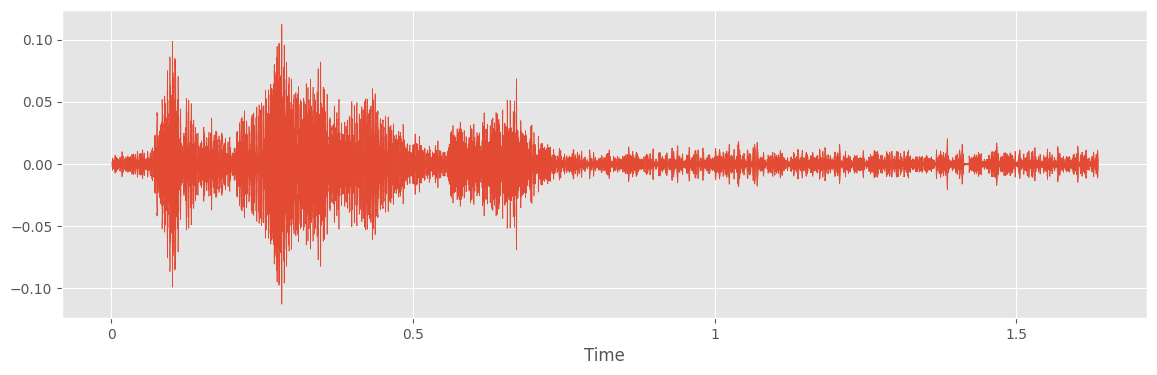

In [ ]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)


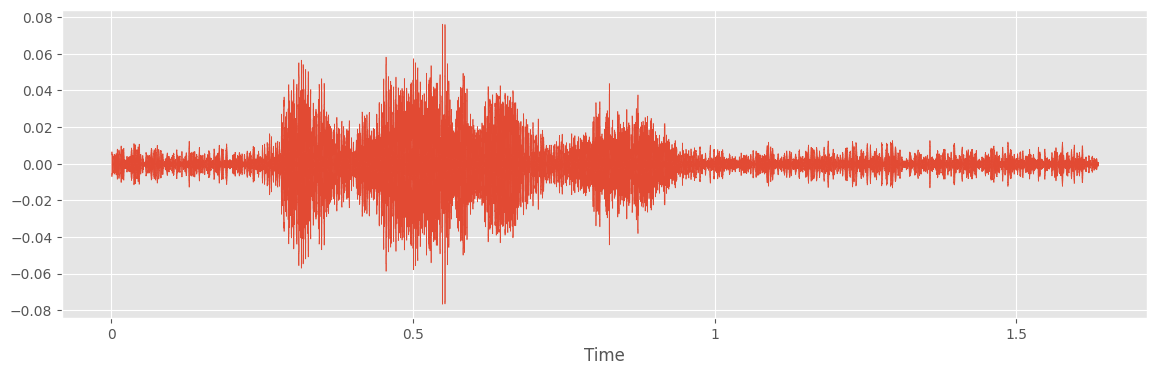

In [ ]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

For our data augmentation we will use noise and pitch and combination with both of it.

### Feature extraction

#### There are some features may be useful:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
3. Spectral Centroid : The center of gravity of the spectrum.
4. Spectral Spread : The second central moment of the spectrum.
5. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
6. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
7. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
8. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [ ]:
n_fft = 2048
hop_length = 512

In [ ]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


# def spc_entropy(data, sr):
#     spc_en = spectral_entropy(data, sf=sr, method="fft")
#     return spc_en

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [ ]:
path = np.array(df["Path"])[658]
data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

33857

In [ ]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
# print("Spectral Entropy: ", spc_entropy(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)
print("Melspectrogram: ",np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0).shape)


ZCR:  (67,)
Energy:  (67,)
Entropy of Energy : (67,)
RMS : (67,)
Spectral Centroid : (67,)
Spectral Flux:  ()
Spectral Rollof:  (67,)
Chroma STFT:  (804,)
MelSpectrogram:  (8576,)
MFCC:  (1340,)
Melspectrogram:  (128,)


In [ ]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        np.mean(energy(data, frame_length, hop_length),axis=0),
                        # np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
                        # mel_spc(data, sr, frame_length, hop_length, flatten=True)
                        # mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [ ]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(df.Path, df.Emotion, range(df.Path.shape[0])):
    features = get_features(path)
    # print(features.shape)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")

    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    # print(len(X[0]))
    # print(X)
    # print(len(Y))
    # break
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
2500 samples has been processed...
2600 samples has been processed...
2700 samples has been processed...
2800 sampl

Let's save our features as DataFrame for further processing:

In [ ]:
features_path = "./features_original.csv"
features_path_2d = "./features_2d.csv"

In [ ]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.shape

(29768, 218)

In [ ]:
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,labels
0,0.104980,0.090424,0.024902,0.305176,0.000105,0.000114,1.062261e-11,0.000571,0.009428,0.004256,...,-9.041139,9.518835,-9.708546,5.455869,-15.741243,8.217480,-12.229836,-0.366455,-6.538229,disgust
1,0.128485,0.080798,0.039062,0.306152,0.000107,0.000114,2.651942e-08,0.000573,0.009498,0.004233,...,-6.312001,3.399702,-2.636754,-2.179586,-6.228366,-1.605452,-5.274396,-4.573287,-3.134465,disgust
2,0.099713,0.079553,0.014160,0.269531,0.000066,0.000081,3.853490e-08,0.000427,0.007337,0.003748,...,-5.085321,9.065780,-7.042300,2.544431,-16.039499,7.824838,-14.309168,0.958368,-7.143571,disgust
3,0.129456,0.072096,0.055664,0.276367,0.000067,0.000080,1.674390e-07,0.000417,0.007417,0.003664,...,-4.104853,3.826753,-2.417537,-3.914157,-6.546738,-1.769802,-6.368895,-4.816225,-2.748286,disgust
4,0.040972,0.017050,0.016113,0.082031,0.000086,0.000117,3.905706e-06,0.000530,0.008602,0.005401,...,-8.279093,1.721925,-6.872144,4.674344,-10.990757,2.761567,-11.042258,2.074491,-1.274224,happy


### Data Reading

In [ ]:
features_path = "/kaggle/input/zcr-rmse/features_final.csv"
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(29768, 217)


In [ ]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(np.sum(extracted_df[100] != 0))
extracted_df.shape


28920


(29768, 218)

In [ ]:
extracted_df.head(10)

## 2D

### Feature Extraction

In [ ]:
n_fft = 2048
hop_length = 512

In [ ]:
import torchaudio
import torchaudio.transforms as transforms
from tqdm import tqdm

S_dB_Total = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for idx, path in tqdm(enumerate(df.Path)):
    waveform, sample_rate = torchaudio.load(path)

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # Convert to tensor
    waveform = torch.tensor(waveform).to(device)

    # Convert to mel spectrogram
    mel_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ).to(device)

    S = mel_transform(waveform)

    # Convert to dB
    power_to_db = transforms.AmplitudeToDB()
    S_dB = power_to_db(S)

    S_dB_Total.append(S_dB.squeeze())

7442it [01:22, 90.23it/s] 


In [ ]:
sizes=[]
for x in S_dB_Total:
    sizes.append(x.shape[1])

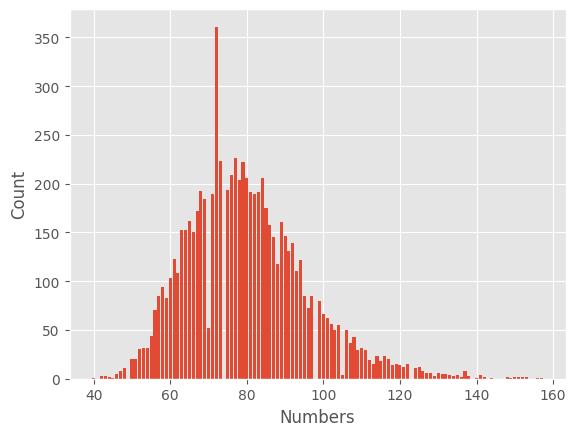

min is 40
max is 157


In [ ]:
# Calculate the bin counts
bincount_array = np.histogram(sizes, bins=np.arange(min(sizes), max(sizes)+2))[0]

# Create a list of labels for the x-axis
x_labels = np.arange(min(sizes), max(sizes)+1)

# Plot the bin counts as a bar plot
plt.bar(x_labels, bincount_array)

# Set labels and title
plt.xlabel('Numbers')
plt.ylabel('Count')
plt.show()

print(f'min is {min(sizes)}')
print(f'max is {max(sizes)}')

In [ ]:
import numpy as np
padding_length = 160
padded_list = []
for array in S_dB_Total:
    current_shape = array.cpu().shape
    padding = [(0, 0), (0, padding_length - current_shape[1])]
    padded_array = np.pad(array.cpu(), padding, mode='constant', constant_values=0)
    padded_list.append(padded_array)

# Convert the padded list to a NumPy array
data_2D = np.array(padded_list)


In [ ]:
data_2D.shape

(7442, 128, 160)

In [ ]:
df.Emotion.unique()


array(['disgust', 'happy', 'sad', 'neutral', 'fear', 'angry'],
      dtype=object)

In [ ]:
df.Emotion.head()

0    disgust
1      happy
2      happy
3    disgust
4    disgust
Name: Emotion, dtype: object

In [ ]:
#normalization
from sklearn.preprocessing import MinMaxScaler

# Reshape the array to 2D
reshaped_data = data_2D.reshape((-1, 1))

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
normalized_data = normalized_data.reshape(data_2D.shape)

In [ ]:
normalized_data[1]

array([[0.62733775, 0.640122  , 0.6647765 , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.5898795 , 0.59867305, 0.6470086 , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.5187135 , 0.5942637 , 0.6223626 , ..., 0.64415836, 0.64415836,
        0.64415836],
       ...,
       [0.48149693, 0.4833352 , 0.47374046, ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.4888742 , 0.48686188, 0.4803564 , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.48625338, 0.4829375 , 0.48455703, ..., 0.64415836, 0.64415836,
        0.64415836]], dtype=float32)

In [ ]:
data=np.expand_dims(normalized_data, axis=1)

In [ ]:
labels=df.Emotion.replace({'disgust': 1, 'happy': 2, 'sad': 3, 'neutral': 4, 'fear': 5, 'angry': 6}).to_numpy()

In [ ]:
labels.shape

(7442,)

In [ ]:
np.unique(labels)

array([1, 2, 3, 4, 5, 6])

In [ ]:
data.shape

(7442, 1, 128, 160)

In [ ]:
data = np.transpose(data, (0, 2, 3, 1))


In [ ]:
data.shape

(7442, 128, 160, 1)

In [ ]:
labels.shape

(7442,)

# Model Training & Evaluation

## 1D



```
# This is formatted as code
```

### **Import Libraries**

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
dmitrybabko_speech_emotion_recognition_en_path = kagglehub.dataset_download('dmitrybabko/speech-emotion-recognition-en')

print('Data source import complete.')


In [ ]:
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### **Read The Data**

In [ ]:
df = pd.read_csv("/kaggle/input/zcr-rmse/features_final.csv")

### **Fill NaN Values With Zeros**

In [ ]:
df.fillna(0, inplace = True)

### **Split The Data into Train & Validation & Test**

In [ ]:
X = df.drop(columns=['labels']).values
y = df['labels'].values

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, train_size = .7, random_state = 42, shuffle = True, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, train_size = .95, random_state = 42, shuffle = True, stratify = y_temp)

### **Normalize Data**

In [ ]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

### **Convert DataFrame Into Tensors and Add The Depth Channel**

In [ ]:
X_train = torch.tensor(X_train).float().unsqueeze(1)
X_test  = torch.tensor(X_test).float().unsqueeze(1)
X_val   = torch.tensor(X_val).float().unsqueeze(1)

### **Apply One Hot Encodding and Convert the labels to Tensors**

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)
y_val = enc.transform(y_val)

In [ ]:
y_train = torch.tensor(y_train.toarray(), dtype=torch.float32)
y_test  = torch.tensor(y_test.toarray(), dtype=torch.float32)
y_val   = torch.tensor(y_val.toarray(), dtype=torch.float32)

### **Create DataLoaders**

In [ ]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size = 64, shuffle = True)
test_loader  = DataLoader(TensorDataset(X_test, y_test),   batch_size = 64, shuffle = False)
val_loader   = DataLoader(TensorDataset(X_val, y_val),     batch_size = 64, shuffle = False)

### **Create Model Architecture**

In [ ]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv1d(1, 512, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

            nn.Conv1d(512, 512, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

            nn.Conv1d(512, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

            nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 6)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc(x)
        return x

### **Create Model And Define Loss Function**

In [ ]:
model = CNN1D()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

### **Training Loop**

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0
best_combination = ()

def train_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        true_labels = torch.argmax(y_batch, dim=1)
        correct_preds += (predicted == true_labels).sum().item()
        total_preds += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total_preds
    return train_loss, train_accuracy


def validate_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            output = model(X_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()

            _, predicted = torch.max(output, 1)
            true_labels = torch.argmax(y_batch, dim=1)
            correct_preds += (predicted == true_labels).sum().item()
            total_preds += y_batch.size(0)

    val_loss = running_loss / len(val_loader)
    val_accuracy = correct_preds / total_preds
    return val_loss, val_accuracy


def train(model, train_loader, val_loader, optimizer, criterion, combo_best_acc, num_epochs=10, checkpoint_path='best_model.pt'):
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_accuracy = validate_epoch(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if val_accuracy > combo_best_acc:
            combo_best_acc = val_accuracy
            torch.save(model.state_dict(), checkpoint_path)

    return combo_best_acc

### **Hyper Parameters Tuning**

In [ ]:
def plot_metrics(title=""):
    plt.figure(figsize=(12, 5))

    plt.suptitle(title, fontsize=14, y=1.05)

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Training with Optimizer: Adam, Learning Rate: 0.01


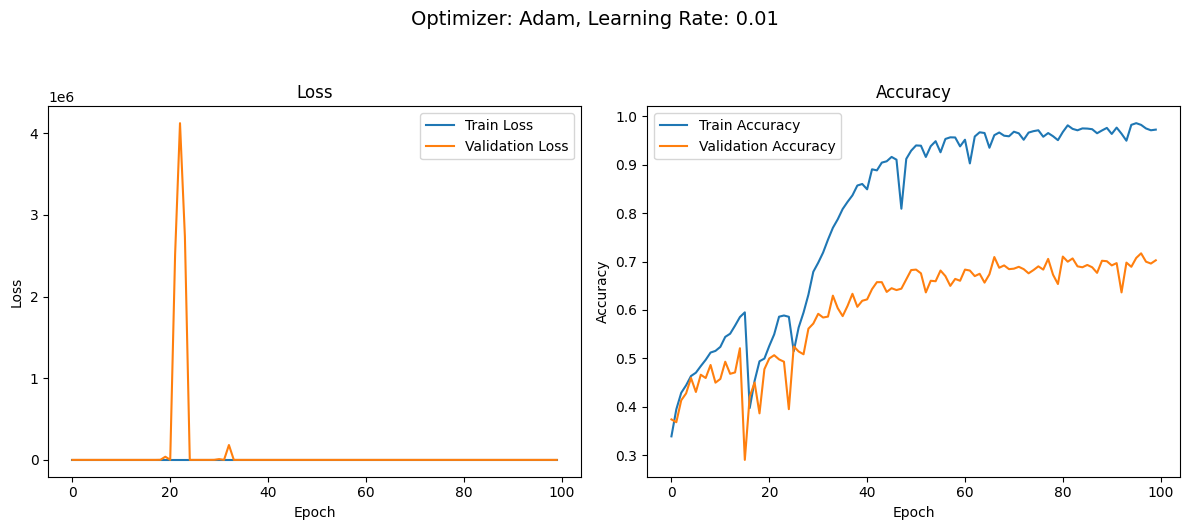


Training with Optimizer: Adam, Learning Rate: 0.001


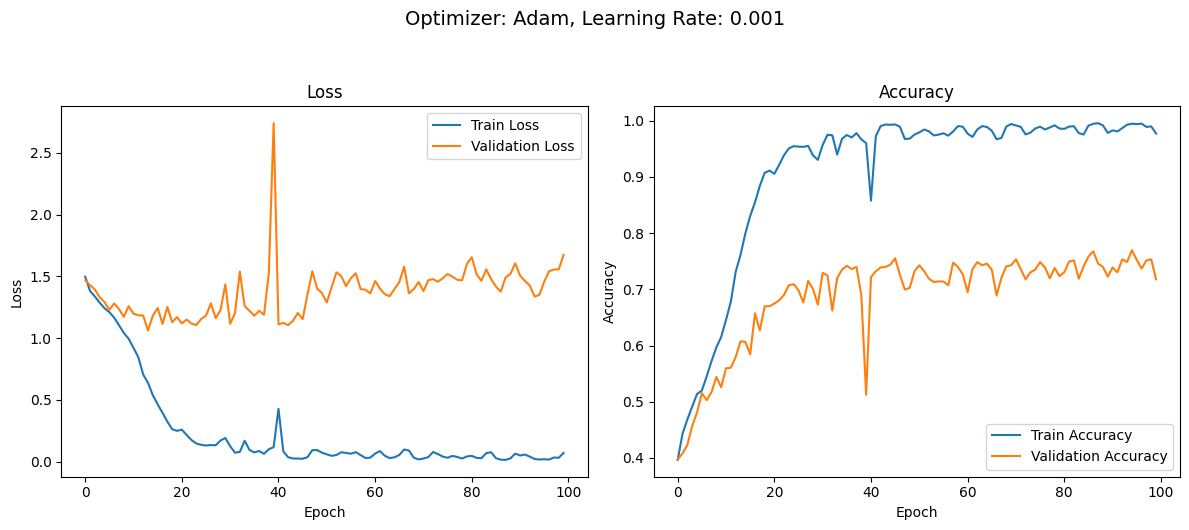


Training with Optimizer: SGD, Learning Rate: 0.01


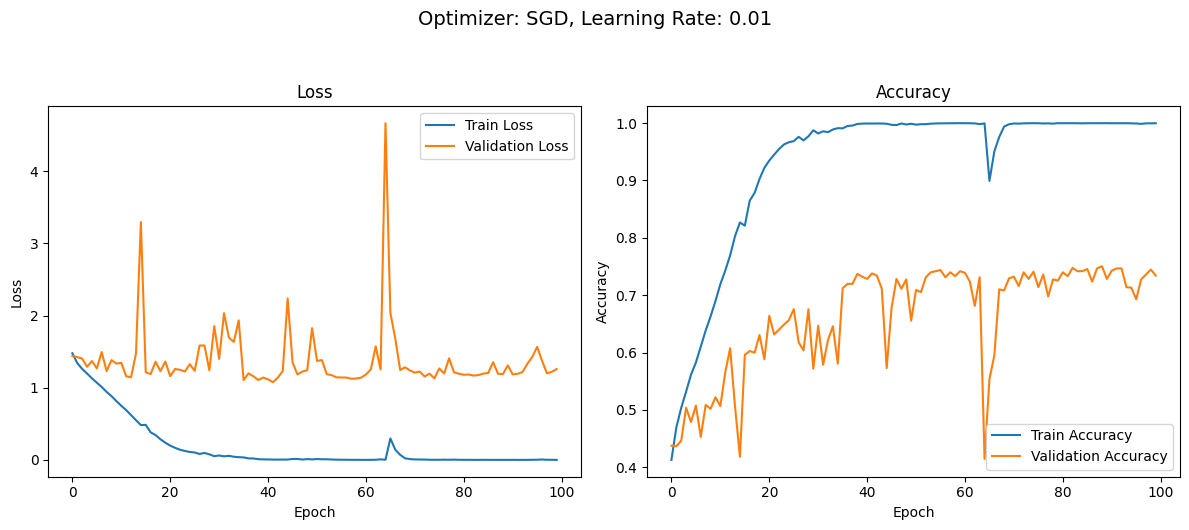


Training with Optimizer: SGD, Learning Rate: 0.001


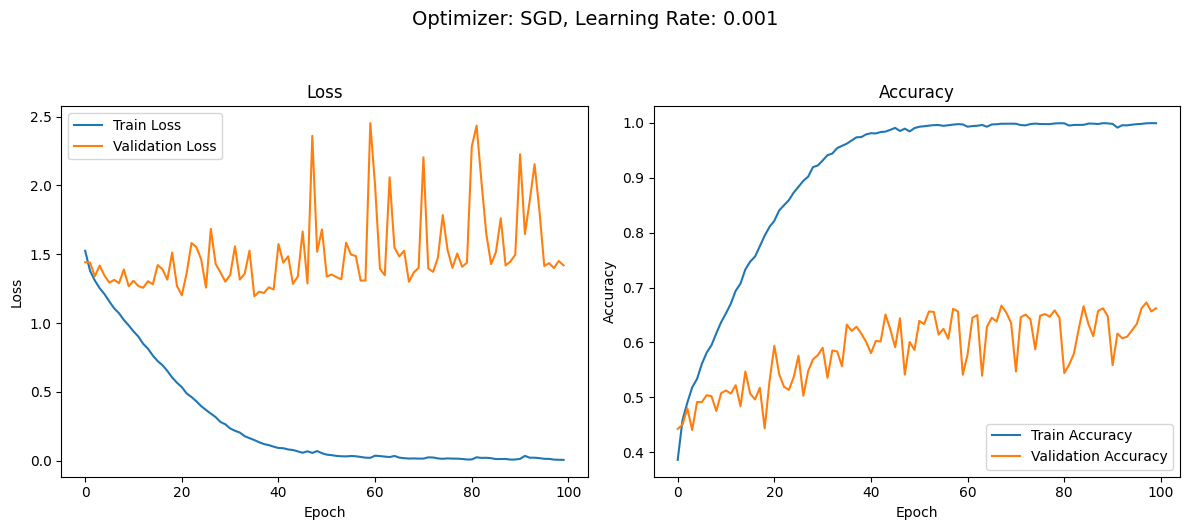


Training with Optimizer: RMSprop, Learning Rate: 0.01


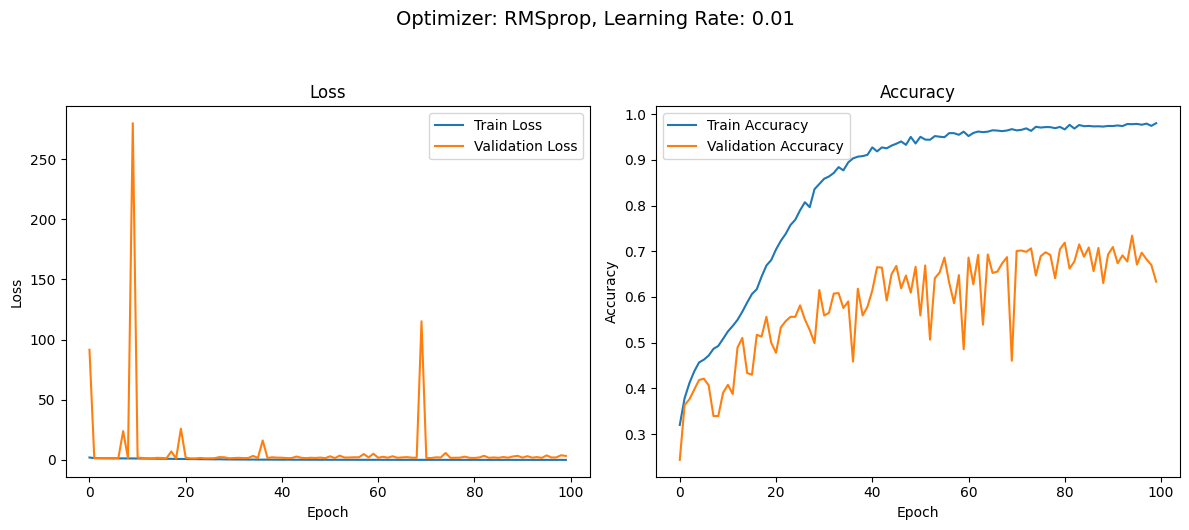


Training with Optimizer: RMSprop, Learning Rate: 0.001


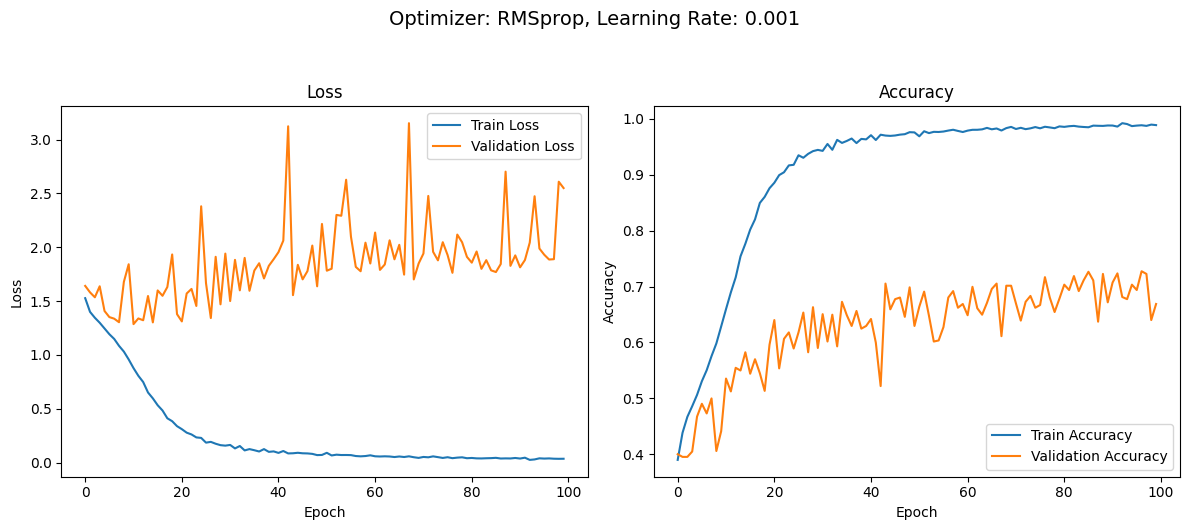

In [ ]:
optimizers = {
    'Adam': optim.Adam,
    'SGD': optim.SGD,
    'RMSprop': optim.RMSprop
}
learning_rates = [0.01, 0.001]

combo_best_acc = 0
best_val_accuracy = 0.0
best_combination = ()

for opt_name, opt_class in optimizers.items():
    for lr in learning_rates:
        print(f"\nTraining with Optimizer: {opt_name}, Learning Rate: {lr}")

        model = CNN1D()
        model.to(device)
        optimizer = opt_class(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        train_losses.clear()
        val_losses.clear()
        train_accuracies.clear()
        val_accuracies.clear()

        combo_best_acc = train(model, train_loader, val_loader, optimizer, criterion, combo_best_acc, num_epochs=100)

        plot_title = f"Optimizer: {opt_name}, Learning Rate: {lr}"
        plot_metrics(title=plot_title)

        if combo_best_acc > best_val_accuracy:
            best_val_accuracy = combo_best_acc
            best_combination = (opt_name, lr)

### **Best Combination**

In [ ]:
print(f"Optimizer: {best_combination[0]}, Learning Rate: {best_combination[1]}")

Optimizer: Adam, Learning Rate: 0.001


### **Evaluate Model on Validation Data**

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, device, categories):
    model.load_state_dict(torch.load('best_model.pt'))
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            output = model(X_batch)
            _, predicted = torch.max(output, 1)
            true_labels = torch.argmax(y_batch, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.7697
F1 Score (Micro): 0.7697
F1 Score (Macro): 0.7686
F1 Score (Weighted): 0.7692


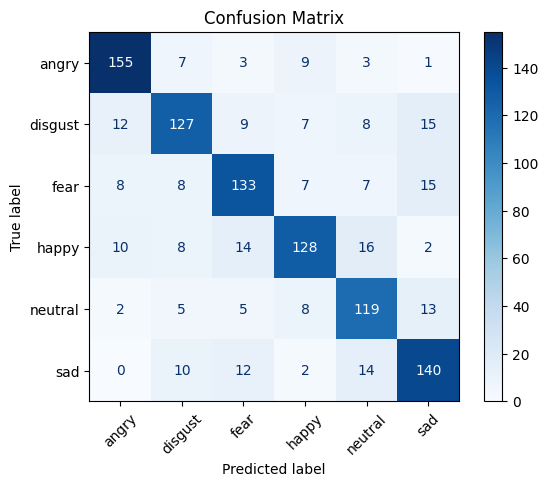

In [ ]:
evaluate_model(model, val_loader, device, ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'])

### **Evaluate Model On Test Data**

Accuracy: 0.7559
F1 Score (Micro): 0.7559
F1 Score (Macro): 0.7557
F1 Score (Weighted): 0.7557


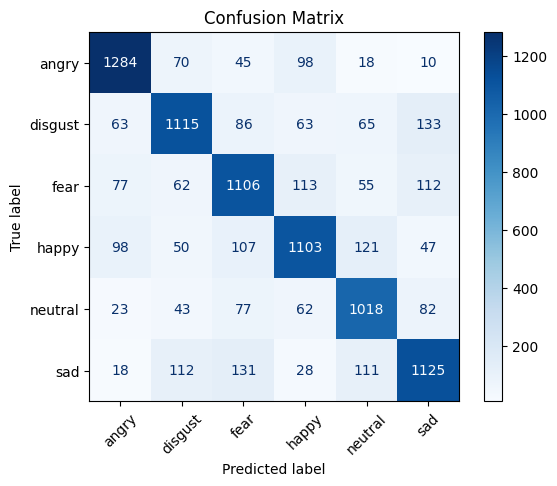

In [ ]:
evaluate_model(model, test_loader, device, ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'])

## 2D

### Import Libraries

In [ ]:


import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Optional: reduce TF logging

import tensorflow as tf

# GPU Memory Growth Setup — MUST BE BEFORE ANY OTHER TF/KERAS CALL
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU detected and memory growth set:", gpus)
    except RuntimeError as e:
        print("⚠️ Could not set memory growth:", e)
else:
    print("❌ No GPU detected. Using CPU.")

# ✅ NOW safe to import the rest
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from IPython.display import Audio
import torch
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score



### Data Split

In [ ]:
# 1) Split raw data & labels
#    “data” here must be shape (N, 1, 128, 160)
#    “labels” is shape (N,)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.05, stratify=y_trainval, random_state=42
)

# 2) One‑hot encode labels
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train = enc.fit_transform(y_train.reshape(-1, 1))
y_val   = enc.transform   (y_val  .reshape(-1, 1))
y_test  = enc.transform   (y_test .reshape(-1, 1))

# 3) Scale pixel values per‑pixel
ns, _, _, _ = X_train.shape
h, w, c    = 128, 160, 1  # known spectrogram dims
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.reshape(-1, h*w*c))
X_val   = scaler.transform   (X_val  .reshape(-1, h*w*c))
X_test  = scaler.transform   (X_test .reshape(-1, h*w*c))

X_train = X_train.reshape(ns, h, w, c)
X_val   = X_val.reshape(-1, h, w, c)
X_test  = X_test.reshape(-1, h, w, c)

# 4) TRANSPOSE ONCE: bring channels last
# X_train = np.transpose(X_train, (0, 1, 2, 3))  # already (N,128,160,1), placeholder
# X_val   = np.transpose(X_val,   (0, 1, 2, 3))
# X_test  = np.transpose(X_test,  (0, 1, 2, 3))

# (If your original data came in (N,1,128,160), use:)
# X_train = np.transpose(X_train, (0, 2, 3, 1))
# X_val   = np.transpose(X_val,   (0, 2, 3, 1))
# X_test  = np.transpose(X_test,  (0, 2, 3, 1))



# 5) Build tf.data.Dataset pipelines
train_dataset = (
    tf.data.Dataset
      .from_tensor_slices((X_train, y_train))
      .shuffle(2000)
      .batch(64)
      .prefetch(tf.data.AUTOTUNE)
)
val_dataset = (
    tf.data.Dataset
      .from_tensor_slices((X_val, y_val))
      .batch(64)
      .prefetch(tf.data.AUTOTUNE)
)
test_dataset = (
    tf.data.Dataset
      .from_tensor_slices((X_test, y_test))
      .batch(64)
      .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
print(data.shape)    # Should be (7442, ...)
print(labels.shape)  # Should be (7442,) or (7442, 1)


In [ ]:

batch = next(iter(train_dataset))

# Unpack inputs and labels
inputs, labels = batch

# Print shapes
print("Inputs shape:", inputs.shape)
print("Labels shape:", labels.shape)

### Model

In [ ]:
def cnn_2d_model(input_shape, num_classes, filters, kernels):
    model = models.Sequential([
        layers.Conv2D(filters[0], kernel_size=kernels[0], strides=1, padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 5), strides=(2, 2), padding='same'),

        layers.Conv2D(filters[0], kernel_size=kernels[0], strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 5), strides=(2, 2), padding='same'),

        layers.Conv2D(filters[1], kernel_size=kernels[1], strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 5), strides=(2, 2), padding='same'),

        layers.Conv2D(filters[2], kernel_size=kernels[2], strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 3), strides=(2, 2), padding='same'),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
filter_sets_2d = [
    (128, 128, 64, 64, 32),
    (512, 256, 256, 128, 64),
    (512, 512, 512, 256, 128)
]


kernel_sets_2d = [
    [(1,3), (3,5), (3,5), (3,3), (3,3)],
    [(3,5), (3,5), (3,5), (3,3), (3,3)],
    [(5,5), (5,5), (3,5), (3,3), (1,3)]
]

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU detected:", gpus)
else:
    print("❌ No GPU detected. Using CPU.")

input_shape_2d = X_train.shape[1:]
results_2d = []
num_classes = 6

for filters in filter_sets_2d:
    for kernels in kernel_sets_2d:
        print(f"\nTraining 2D CNN: filters={filters}, kernels={kernels}")

        model_2d = cnn_2d_model(input_shape_2d, num_classes, filters, kernels)

        history_2d = model_2d.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=200,
            callbacks=[early_stop],
            verbose=0
        )

        y_pred_2d = model_2d.predict(val_dataset)
        y_pred_classes_2d = np.argmax(y_pred_2d, axis=1)

        y_true_classes_2d = np.concatenate(
    [np.argmax(y, axis=1) for _, y in val_dataset.as_numpy_iterator()], axis=0)

        val_acc_2d = max(history_2d.history['val_accuracy'])
        f1_2d = f1_score(y_true_classes_2d, y_pred_classes_2d, average='weighted')

        print(f"→ Val Acc (2D): {val_acc_2d:.4f} | F1 Score (2D): {f1_2d:.4f} | Filters: {filters} | Kernels: {kernels}")
        results_2d.append(((filters, kernels), val_acc_2d, f1_2d))

In [ ]:
full_dataset = (
    tf.data.Dataset
      .from_tensor_slices((np.concatenate([X_train, X_val], axis=0),
                           np.concatenate([y_train, y_val], axis=0)))
      .shuffle(2000)
      .batch(64)
)


In [ ]:
early_stop = EarlyStopping(
    monitor='accuracy',        # or 'accuracy' if preferred
    patience=10,
    restore_best_weights=True
)


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU detected:", gpus)
else:
    print("❌ No GPU detected. Using CPU.")

# Model setup and training
best_filters = (128, 128, 64, 64, 32)
best_kernels = [(1, 3), (3, 5), (3, 5), (3, 3), (3, 3)]
final_model = cnn_2d_model(input_shape_2d, num_classes, best_filters, best_kernels)

history = final_model.fit(
    full_dataset,
    epochs=250,
    callbacks=[early_stop],
    verbose=1
)

In [ ]:
final_train_acc = history.history['accuracy'][-1]
print(f"Final Train Accuracy: {final_train_acc:.4f}")

Final Train Accuracy: 0.9580


In [ ]:
# 6) Get predictions and compute F1 manually
y_pred_probs = final_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Build true labels from test_dataset
y_true_classes = np.concatenate([np.argmax(y, axis=1) for _, y in test_dataset], axis=0)

test_f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
test_acc = accuracy_score(y_true_classes, y_pred_classes)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test Accuracy: 0.5271
Test F1 Score: 0.5317


In [ ]:
labels_dict = {'disgust': 1, 'happy': 2, 'sad': 3, 'neutral': 4, 'fear': 5, 'angry': 6}

# Sort the keys based on their mapped values (1 to 6)
class_names = [k for k, v in sorted(labels_dict.items(), key=lambda item: item[1])]

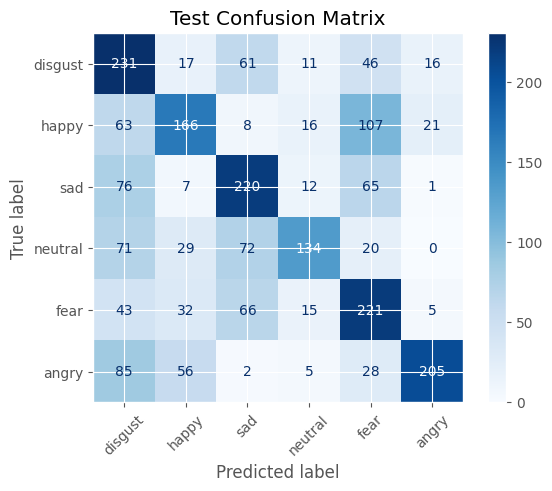

In [ ]:


cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Test Confusion Matrix")
plt.show()
